In [39]:
from datetime import datetime
import random
import sys
sys.path.append('..')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from itertools import chain, combinations
from collections import Counter


from comscore.data import read_weeks_machines_domains, read_comscore_demo_df

# Demonstrating Browsing Differences by Race

A core question left unanswered by our analysis of FLoC's sensitivity is whether racial groups in our dataset exhibit significant browsing behavior differences. If users' browsing history does not vary by racial group, then we should expect any clustering algorithm, including FLoC, to group independently of race. We use a Chi-Squared homogeneity test to test if racial groups' browsing behaviors are independent from race, treating each racial group as a separate population, and the top domains visited in our dataset as the categorical variable of interest. To calculate domain visit frequencies, we construct a set $D_w^m$ consisting of each unique domain visited by a machine $m$ in a given week $w$. 

In [2]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [72]:
comscore_demo_df = (read_comscore_demo_df(fpath="../data/comscore/{year}/demographics.csv", year=2017)
           .assign(machine_id=lambda x: x.machine_id.astype(int))
          )

df = (weeks_machines_domains_df.merge(comscore_demo_df, 
               how='inner', # only include machine_ids with valid data (no nan race)
               left_on='machine_id', 
               right_on='machine_id')
      .query("n_domains > 0")
     )
# convert to list
df.domains = [list(d) for d in df.domains]

To validate the chi-square tests, we also generate a random sample population with an N equal to 1/4 our total population. We uniformly sample across all users in our original cohort and assign a fake, new race identifier - '6.0'. This allows us to compare chi-square significance between this cohort and our real cohorts for a sanity-check.

In [73]:
# random sample
# counts and therefore p-values for random sample will change without consistent sampling
# which is why we plant the random seed
random.seed('hi FLoC') 
samp_df = (df.sample(n = round(len(df) * 0.25))
           .assign(racial_background = 6.0)
          )
df = pd.concat([df, samp_df])

Then, we calculate the frequencies at which each domain appears in the weekly unique domain list for each racial group. This is our categorical distribution, across all races.

In [74]:
# Calculate frequencies for each race group
start_time = datetime.now()
freqs = []
for race in df.racial_background.unique():
    df2 = df[df.racial_background == race]
    counter = pd.Series(Counter(chain.from_iterable(df2.domains)))
    freqs.append(counter)

end_time = datetime.now()
time = end_time - start_time
print('took %s' % (time))

took 0:00:37.152474


In [75]:
races = df.racial_background.unique()
dfs = [(pd.DataFrame(distribution)
       .assign(race=races[i])) for i, distribution in enumerate(freqs)]

race_distributions = (pd.concat(dfs)
                      .reset_index()
                      .rename({'index': 'domain', 0: 'count'}, axis=1)
                     )
total_counts = race_distributions.groupby('race')['count'].sum()

race_distributions['p'] = race_distributions.apply(lambda x: x['count']/total_counts[x['race']], axis=1)

In [76]:
race_distributions.head()

,domain,count,race,p
0,overstock.com,2270,2.0,2.587640e-04
1,ora.tv,66,2.0,7.523536e-06
2,youthhealthmag.com,2,2.0,2.279859e-07
3,adidas.com,1081,2.0,1.232264e-04
4,microsoft.com,33200,2.0,3.784567e-03


Then, we calculate the overall distribution for all races, excluding our randomly sampled sub-population, to be able to compute the top N domains visited in our dataset:

In [77]:
all_distribution = (race_distributions
 .query("race != 6.0")
 .drop(['race', 'p'], axis=1)
 .groupby('domain')
 .aggregate({'count': sum})
 .assign(p=lambda x: x['count'] / x['count'].sum())
)
all_distribution.sort_values('p', ascending=False).head()

,count,p
domain,,
google.com,1411233,0.023044
yahoo.com,947341,0.015469
bing.com,940938,0.015365
msn.com,923215,0.015075
facebook.com,852397,0.013919


Rather than using Chi-Square to test whether all groups are from the same underlying distribution, we construct a series of pairwise Chi-Square tests to test if any two racial groups exhibit similar browsing behavior. We find that each racial group's browsing distributions are significantly different from the overall population, for all values of N.

In [78]:
from scipy.stats import chi2_contingency

def chi_square_data(top_domains):
    race_dist_df = race_distributions[race_distributions.domain.isin(top_domains.index)]
    race_X = (race_dist_df
     [['domain', 'race', 'count']]
     .pivot(index='domain', columns='race')
    )
    return race_X

def chi_square_overall(N, all_dist_df):
    """
    N: N top domains from the aggregated population to consider
    all_dist_df: dataframe of 'all_distribution'
    """
    top_domains = all_dist_df.nlargest(N, columns='p')
    race_X = chi_square_data(top_domains)
    df = race_X['count']
    results = []
    for col in df.columns:
        X = pd.concat([df[col], top_domains['count']], axis=1).values
        results.append(chi2_contingency(X))
    return results

def chi_square_pairwise(N, all_dist_df):
    top_domains = all_dist_df.nlargest(N, columns='p')
    race_X = chi_square_data(top_domains)
    pairs = combinations([c[1] for c in race_X.columns], r=2)
    df = race_X['count']
    results = []
    for c1, c2 in pairs:
        X = pd.concat([df[c1], df[c2]], axis=1).values
        results.append(chi2_contingency(X)) # chi2, p, dof, ex = chi2_contingency(X)
    return results

In [79]:
MAX_D = 100
race_X = chi_square_data(all_distribution.nlargest(MAX_D, columns='p'))
race_X.sort_values(('count', 6.0)).head()

count                         
race                   1.0   2.0   3.0   5.0    6.0
domain                                             
dropbox.com          25210  5367  2963  4842   9629
verizonwireless.com  30295  3700  1632  3727   9784
washingtonpost.com   29308  3623  2689  4388   9896
safesear.ch          21753  9603  2229  5652   9924
camdolls.com         27065  6380  2515  4717  10141

In [80]:
results = []
for N in np.arange(10, MAX_D+10, 10):
    overall = chi_square_overall(N, all_distribution)
    pairwise = chi_square_pairwise(N, all_distribution)
    overall_p = [r[1] for r in overall]
    pairwise_p = [r[1] for r in pairwise]
    results.append((N, overall_p, pairwise_p))

print("Overall dataframe:")
pvals = [r[1] for r in results]
Ns = [r[0] for r in results]
chi_df = pd.DataFrame(pvals, columns=race_X['count'].columns)
chi_df['N'] = Ns
chi_df

Overall dataframe:


race,1.0,2.0,3.0,5.0,6.0,N
0,0.0,0.0,0.0,0.0,0.715102,10
1,0.0,0.0,0.0,0.0,0.949342,20
2,0.0,0.0,0.0,0.0,0.996743,30
3,0.0,0.0,0.0,0.0,0.999375,40
4,0.0,0.0,0.0,0.0,0.999809,50
5,0.0,0.0,0.0,0.0,0.999432,60
6,0.0,0.0,0.0,0.0,0.999756,70
7,0.0,0.0,0.0,0.0,0.999620,80
8,0.0,0.0,0.0,0.0,0.999706,90
9,0.0,0.0,0.0,0.0,0.999945,100


---
# Plots

While the Chi-Square test demonstrates that there *is* a difference in browsing behavior between racial groups, it doesn't show the degree of that difference. To get a sense for differences in behavior, two plots displaying distributions over domain frequencies are below. The first is grouped, which gives a better sense of overall domains, and the second is faceted, which provides a sense of the actual differences in shape:

In [89]:
from plotnine import (ggplot, geom_point, aes, stat_smooth, 
                      facet_wrap, geom_bar, element_text, 
                      theme, theme_minimal, labs, element_blank, 
                      element_line)

# Organize data
race_values = {1:'white', 2:'black', 3:'asian', 5:'other', 6: 'random control', 7: 'any'}
# get top 50 for demonstration
top_domains = all_distribution.nlargest(50, columns='p')
race_dist_df = race_distributions[race_distributions.domain.isin(top_domains.index)]
# calc frequencies
race_X = (race_dist_df
 [['domain', 'race', 'count']]
 .pivot(index='domain', columns='race')
)
plot_df = (pd.concat([(top_domains.reset_index()
                       .rename({'index': 'domain'}, axis=1)
                       .assign(race=7)), 
                      race_dist_df])
           # convert to readable strings, then categorical vars
           .assign(race = lambda x: x.race.astype(int).map(race_values))
           .assign(race=lambda x: pd.Categorical(x.race, categories=x.race.unique().sort()),
                   domain=lambda x: pd.Categorical(x.domain, categories=x.domain.unique()),
                   p=lambda x: x.p.astype(float))
          )

# adds p_any (from aggregate) to DF for plotting convenience
p_any_df = (plot_df[plot_df.race == 'any'][['domain', 'p']])
p_domains_any = plot_df[plot_df.race == 'any'][['domain', 'p']].set_index('domain').to_dict()['p']
plot_df = plot_df.assign(p_any=lambda x: x.domain.map(p_domains_any).astype(float))
plot_df.head()

,domain,count,p,race,p_any
0,google.com,1411233,0.023044,any,0.023044
1,yahoo.com,947341,0.015469,any,0.015469
2,bing.com,940938,0.015365,any,0.015365
3,msn.com,923215,0.015075,any,0.015075
4,facebook.com,852397,0.013919,any,0.013919


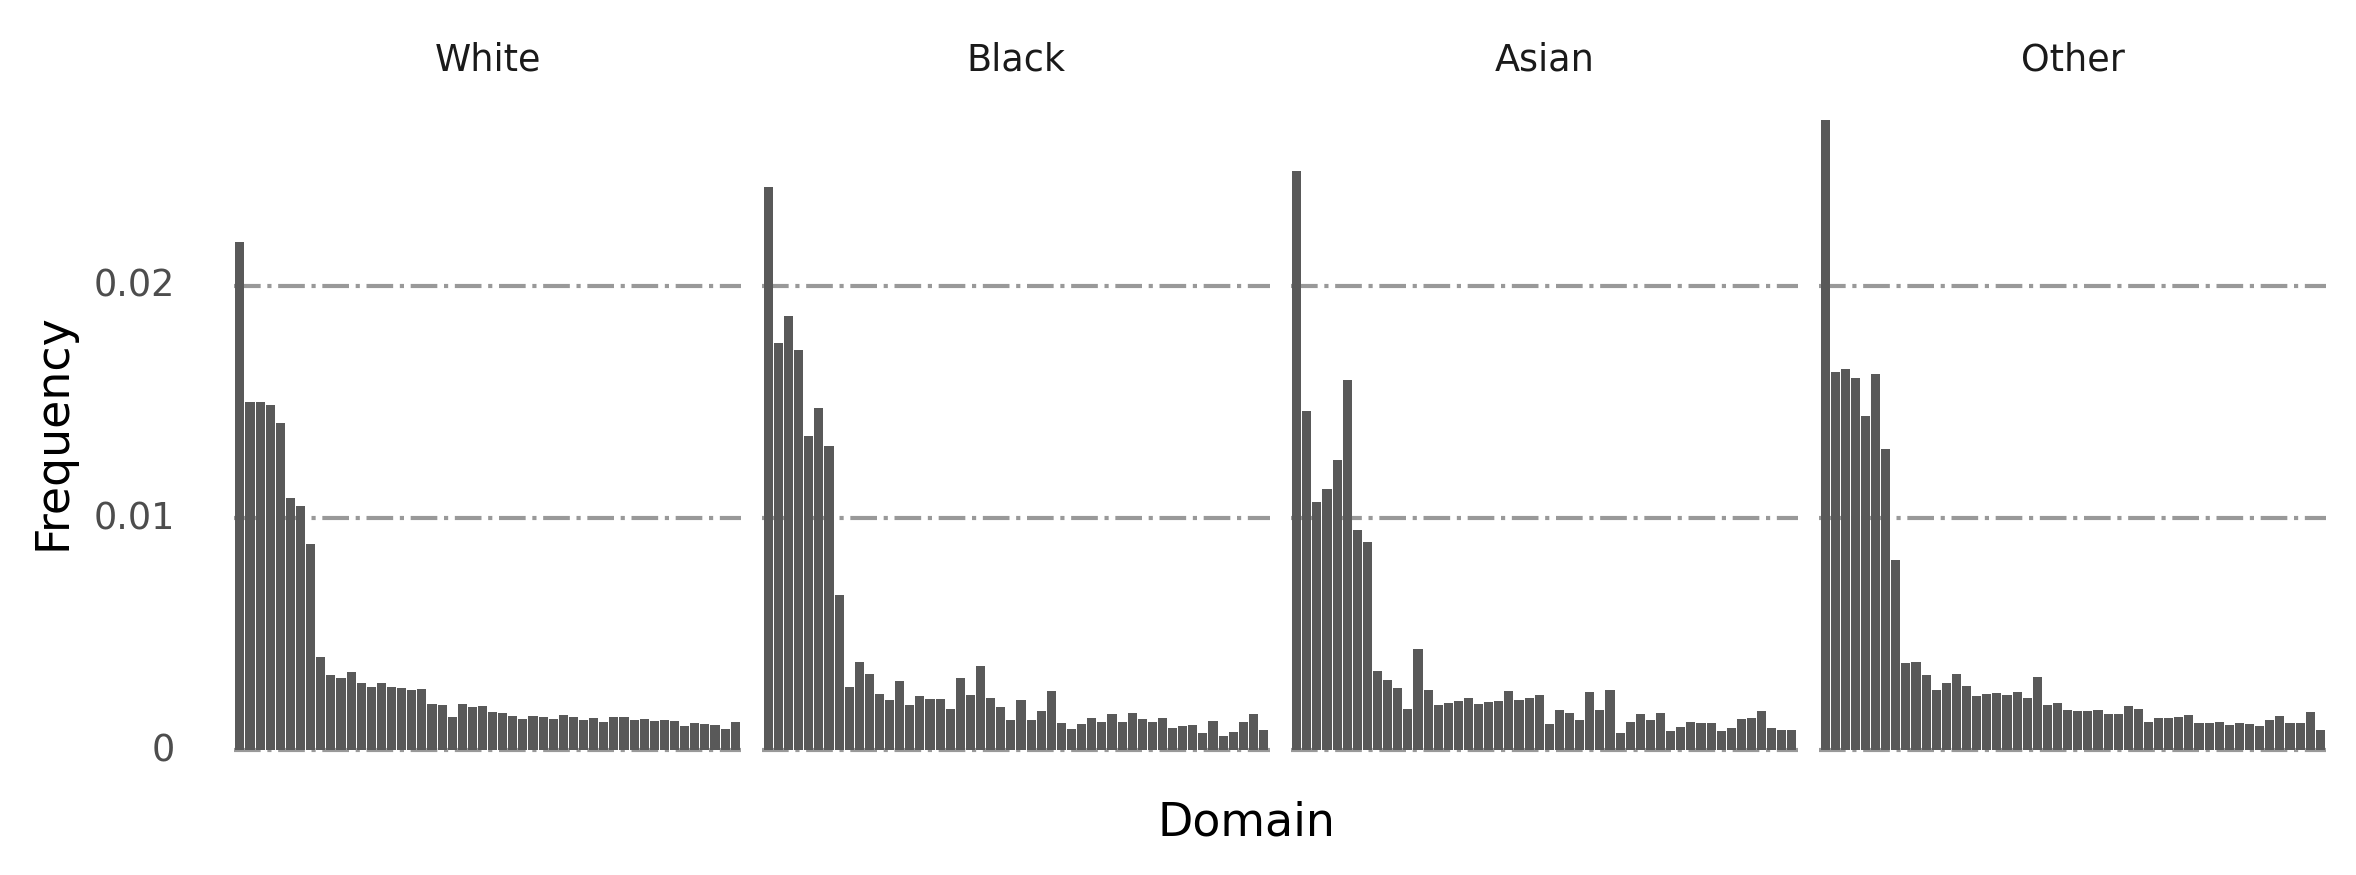

<ggplot: (-9223363252888533984)>

In [92]:
from plotnine import geom_density, geom_col
(plot_df
 # reorder
 .assign(race=lambda x: x.race.cat.reorder_categories([
     "white", 
     "black", 
     "asian", 
     "other", 
     "random control", 
     "any"]))
 # remove any and control
 .query("race != 'any' & race != 'random control'")
 # capitalize for plot titles
 .assign(race=lambda x: x.race.cat.rename_categories(lambda x: x.capitalize()))
 .pipe(lambda x:
     ggplot(x, aes(x='reorder(domain, -p_any)', y='p')) +
#       geom_density() +
     geom_col(position='dodge', width=0.9, alpha=1) +
     theme_minimal() +
     theme(axis_text_x=element_blank(),
          panel_grid=element_blank(),
          panel_grid_major_y = element_line(linetype='dashdot', size=1, alpha=0.4)) +
#          panel_grid_minor_y = element_line(linetype='dashed', size=0.4, alpha=0.4)) +
     labs(x="Domain", y="Frequency") +
     facet_wrap('~race', nrow=1) +
     theme(legend_position='bottom', 
           dpi=300,
           figure_size=(9,3))
))

Although the distributions are generally shaped similarly, there are significant differences in overall frequencies to the top few sites overall.

Aggregating across weeks for each racial group, this gives us a distribution over all domains in our dataset. For example, here are the top D domains visited by each racial group in the comscore data:

# Table: Browsing distributions, top D

In [140]:
# above plot_df was for D=50.
# show D=100
# Organize data the same way as before
race_values = {1:'white', 2:'black', 3:'asian', 5:'other', 6: 'random control', 7: 'overall'}
top_domains = all_distribution.nlargest(100, columns='p')
race_dist_df = race_distributions[race_distributions.domain.isin(top_domains.index)]
# calc frequencies
race_X = (race_dist_df
 [['domain', 'race', 'count']]
 .pivot(index='domain', columns='race')
)
plot_df = (pd.concat([(top_domains.reset_index()
                       .rename({'index': 'domain'}, axis=1)
                       .assign(race=7)), 
                      race_dist_df])
           # convert to readable strings, then categorical vars
           .assign(race = lambda x: x.race.astype(int).map(race_values))
           .assign(race=lambda x: pd.Categorical(x.race, categories=x.race.unique().sort()),
                   domain=lambda x: pd.Categorical(x.domain, categories=x.domain.unique()),
                   p=lambda x: x.p.astype(float))
          )

# adds p_any (from aggregate) to DF for plotting convenience
p_any_df = (plot_df[plot_df.race == 'overall'][['domain', 'p']])
p_domains_any = plot_df[plot_df.race == 'overall'][['domain', 'p']].set_index('domain').to_dict()['p']
plot_df = plot_df.assign(p_any=lambda x: x.domain.map(p_domains_any).astype(float))

top_browsing_df = (plot_df
 .groupby('race')
 .apply(lambda x: x.nlargest(100, columns='p_any'))
 [['domain', 'race', 'p']]
 .pivot(index='domain', columns='race')
 ['p']
 .applymap(lambda x: '{0:.3%}'.format(x))
)[['overall', 'white', 'black', 'asian', 'other', 'random control']].reset_index()
top_browsing_df.index.names = ['index']
top_browsing_df = top_browsing_df.reset_index()
top_browsing_df['index'] = top_browsing_df['index'] + 1
top_browsing_df = top_browsing_df.set_index('index')
top_browsing_df

race,domain,overall,white,black,asian,other,random control
index,,,,,,,
1,google.com,2.304%,2.186%,2.424%,2.493%,2.712%,2.284%
2,yahoo.com,1.547%,1.498%,1.754%,1.458%,1.627%,1.531%
3,bing.com,1.536%,1.498%,1.871%,1.067%,1.643%,1.523%
4,msn.com,1.508%,1.487%,1.724%,1.123%,1.603%,1.495%
5,facebook.com,1.392%,1.408%,1.352%,1.248%,1.440%,1.374%
...,...,...,...,...,...,...,...
96,camdolls.com,0.066%,0.066%,0.073%,0.056%,0.066%,0.066%
97,washingtonpost.com,0.065%,0.072%,0.041%,0.060%,0.061%,0.064%
98,verizonwireless.com,0.064%,0.074%,0.042%,0.036%,0.052%,0.063%


In [141]:
print(top_browsing_df.to_latex())

\begin{tabular}{llllllll}
\toprule
race &                 domain & overall &   white &   black &   asian &   other & random control \\
index &                        &         &         &         &         &         &                \\
\midrule
1     &             google.com &  2.304\% &  2.186\% &  2.424\% &  2.493\% &  2.712\% &         2.284\% \\
2     &              yahoo.com &  1.547\% &  1.498\% &  1.754\% &  1.458\% &  1.627\% &         1.531\% \\
3     &               bing.com &  1.536\% &  1.498\% &  1.871\% &  1.067\% &  1.643\% &         1.523\% \\
4     &                msn.com &  1.508\% &  1.487\% &  1.724\% &  1.123\% &  1.603\% &         1.495\% \\
5     &           facebook.com &  1.392\% &  1.408\% &  1.352\% &  1.248\% &  1.440\% &         1.374\% \\
6     &            youtube.com &  1.241\% &  1.086\% &  1.471\% &  1.593\% &  1.620\% &         1.226\% \\
7     &               live.com &  1.108\% &  1.049\% &  1.310\% &  0.947\% &  1.297\% &         1.099\% \\
8     